# Ensemble methods for individual customer OrderQuantity value prediction

In [17]:
%pip install nbformat pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append('../../src')

In [3]:
from data_config import ProductHandler as ph

d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:13: DtypeWarning: Columns (4,6,20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  products_s = pd.read_csv(
d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:15: DtypeWarning: Columns (5,29,42,48) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_i = pd.read_csv(
d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:18: DtypeWarning: Columns (43,57,106,141,146,211,212,247,255,294,298,316,327,332,350,354) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv(
d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:21: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sp_inv_adds = pd.read_csv(


----- DROP BOOLEAN AND NULL COLUMNS (NOT NEEDED) -----

Merged Data - Columns to be dropped (Missing Vals): ['BackStage_DefaultReportForm', 'BackStage_SmartMarkSet', 'BillCounty', 'CoreType', 'EndUserNum', 'EndUserPO', 'Equip3_ID', 'Equip3_Status', 'Est_v_Act_Notes', 'Ink_Status', 'JDF_Note_to_DFE', 'JDF_Send_Msg', 'MiscChargeDesc1', 'MiscChargeDesc2', 'MiscChargeDesc3', 'MiscChargeDesc4', 'PlateStat', 'ProofStat', 'Roto_CEL_Product_ID', 'Roto_Quote_Line_ID', 'Roto_Quote_Number', 'Schedule_Status', 'ShipAttn_EmailAddress', 'ShipCounty', 'ShipStat', 'Tag_x', 'Tool3Descr', 'Tool4Descr', 'Tool5Descr', 'ToolNo3', 'ToolNo4', 'ToolNo5', 'ToolStat', 'UserDef_MR_1_Lb', 'UserDef_MR_2_Lb', 'Assigned', 'Desc2_x', 'ediLineNumber', 'eTraxx_Customer_Notes', 'Location_x', 'PO_Number', 'Adhesive', 'Alternate', 'eTraxx_Forecast_Range', 'Material', 'Tag_y', 'UPC']

Merged Data - Columns to be dropped (All cols with rows same vals): ['Act_OTHER_Hours', 'ActArtwork', 'ActFinMaterial', 'ActPostPressHours',

d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(
d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(
d:\SCM---ML-Visualisation\notebooks\ensemble\../../src\datasets.py:110: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Ship_by_Date'] = pd.to_

In [4]:
ph.custom_prod_set()

All custom codes for existing products: 
{'J-T', '681', '18U', '25T', '32T', 'B-T', 'S-R', '509', '18W', '471', '260', '265', 'DSF', '877', 'MS-', '37Z', '55X', '22W', 'VO-', 'UNC', 'MLC', 'NAF', 'GRK', '21W', '413', '5Z-', 'CON', '40Z', '88U', '078', 'URB', '055', '497', '856', '536', 'NEL', '98U', '444', '19V', '610', '629', '426', '239', '565', '480', '824', '47Z', '954', '479', '27T', '34X', 'WF-', '180', '492', '61W', 'QQ-', 'TRI', '741', '55T', '765', '91X', 'LC-', 'CUL', '46V', '68Y', 'EVR', '-08', '368', '44Y', '579', '604', '385', '64U', '27Q', '668', '63V', '20T', '279', '539', '290', '26T', '35W', 'NUT', 'W-0', '142', 'BH-', '549', 'QU-', '18Z', 'CSI', '592', '33U', '420', '41X', 'GDW', '209', '643', 'BLE', '130', 'CP-', 'SS-', '09T', '528', '25X', '330', '607', '22V', '60Z', '70W', 'IV-', 'RL-', '810', 'AUS', 'TI-', '240', 'JMJ', '916', '772', '737', '002', '16Y', '148', 'HF-', '874', 'GS-', '339', 'FRE', '27R', '98T', '308', '898', '398', '165', 'EN-', '384', '120', '032',

In [5]:
# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('FRE'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

FRE


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,FRE-005-0006Y,2022,1,3,1,0,66.0,40000,80000.00000,80000.00000,...,53333.333333,61000.000000,61000.000000,61000.000000,40000,0,0,-100.0,NaN,0
1,FRE-005-0006Y,2022,3,10,2,0,66.0,80000,40000.00000,40000.00000,...,50000.000000,66250.000000,66250.000000,66250.000000,80000,0,0,-100.0,NaN,0
2,FRE-005-0006Y,2022,4,14,3,0,66.0,40000,30000.00000,30000.00000,...,61666.666667,61666.666667,61666.666667,61666.666667,40000,0,0,-100.0,NaN,0
3,FRE-005-0006Y,2022,6,24,1,0,66.0,30000,115000.00000,115000.00000,...,72500.000000,72500.000000,72500.000000,72500.000000,30000,0,0,-100.0,NaN,0
4,FRE-005-0006Y,2022,7,30,1,0,66.0,115000,110031.53337,110031.53337,...,115000.000000,115000.000000,115000.000000,115000.000000,115000,0,0,-100.0,NaN,0


In [6]:
from scipy import stats

# Define a function to compute z-scores within each product group
def compute_zscore(group, threshold=3):
    # Only compute z-score if there are at least 2 data points in the group
    if len(group) >= 2:
        group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
    else:
        group['z_score'] = 0  # or np.nan if preferred
    return group

# Group by "ProductNumber" and compute z-scores for "OrderQuantity" within each group
df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)

# Define your threshold for what constitutes an "unusually high" order
z_threshold = 3

# Filter for outliers (orders with a z_score greater than the threshold)
df_outliers = df_grouped[df_grouped['z_score'] > z_threshold]

# Display the results
print("Unusually high order quantities (per ProductNumber):")
print(df_outliers[['ProductNumber', 'OrderQuantity', 'z_score']])

print(f'Dropping: \n{df_outliers.count()}')
# Keep only rows where the z-score is within the acceptable range
df_cleaned = df_grouped[df_grouped['z_score'] <= z_threshold].drop(columns=['z_score'])

# Reset index for clarity
df_cleaned.reset_index(drop=True, inplace=True)

custom_code_df = df_cleaned

C:\Users\44777\AppData\Local\Temp\ipykernel_2532\4254259826.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_2532\4254259826.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_2532\4254259826.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_2532\4254259826.py:7: RuntimeWarning: Precision

Unusually high order quantities (per ProductNumber):
                    ProductNumber  OrderQuantity   z_score
ProductNumber                                             
FRE-005-0015Y 48    FRE-005-0015Y         475000  4.034252
FRE-005-0016Z 104   FRE-005-0016Z         210000  3.438802
FRE-005-0019Z 169   FRE-005-0019Z         420000  3.244338
FRE-005-0024Y 238   FRE-005-0024Y         465000  3.440847
FRE-005-0045Z 418   FRE-005-0045Z        1440000  3.292242
FRE-005-0049Z 497   FRE-005-0049Z         720000  3.850058
FRE-005-0076Z 1067  FRE-005-0076Z         170000  3.678452
FRE-005-0081Z 1197  FRE-005-0081Z         375000  3.783414
FRE-005-0087Y 1397  FRE-005-0087Y         202500  3.417696
FRE-005-0090Z 1495  FRE-005-0090Z         315000  3.110541
FRE-005-0105X 1919  FRE-005-0105X         262500  3.215675
FRE-005-0111Y 2007  FRE-005-0111Y         457500  3.224130
FRE-005-0112W 2025  FRE-005-0112W         532500  3.190349
FRE-005-0115X 2054  FRE-005-0115X         150000  3.566041
FRE

C:\Users\44777\AppData\Local\Temp\ipykernel_2532\4254259826.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
features = ['ProductNumber', 'order_month', 'order_week', 'order_weekday',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024']
target = 'OrderQuantity'

# Define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = [col for col in features if col not in categorical_features]

# Preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

In [9]:
df = custom_code_df

X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data (fit and transform used so the preprocessor learns the features)
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the validation data
X_val_preprocessed = preprocessor.transform(X_val)

# Extract feature names from the fitted pipeline
encoded_cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)

# Combine categorical and numeric feature names
all_feature_names = list(encoded_cat_features) + numeric_features

# Convert preprocessed data back to DataFrame with correct feature names and index
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names, index=X_train.index)
X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=all_feature_names, index=X_val.index)

In [10]:
customer_total_df = custom_code_df

total_X = customer_total_df[features]
total_y = customer_total_df[target]

total_X_train, total_X_val, total_y_train, total_y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data (fit and transform used so the preprocessor learns the features)
total_X_train_preprocessed = preprocessor.fit_transform(total_X_train)

# Transform the validation data
total_X_val_preprocessed = preprocessor.transform(total_X_val)

# Extract feature names from the fitted pipeline
encoded_cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)

# Combine categorical and numeric feature names
all_feature_names = list(encoded_cat_features) + numeric_features

# Convert preprocessed data back to DataFrame with correct feature names and index
total_X_train_preprocessed_df = pd.DataFrame(total_X_train_preprocessed, columns=all_feature_names, index=X_train.index)
total_X_val_preprocessed_df = pd.DataFrame(total_X_val_preprocessed, columns=all_feature_names, index=X_val.index)

In [34]:
from model_utils import *
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Stacking ensemble
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

In [37]:
rf_tuned = RandomForestRegressor( # Tuned model hyperparams from rf ipynb
    criterion='squared_error',
    max_depth=None, 
    min_samples_leaf=2, 
    min_samples_split=2, 
    n_estimators=200, 
    random_state=42
)

mlp_tuned = MLPRegressor( # Tuned model hyperparams from nn ipynb
    activation='relu', 
    alpha=0.001, 
    early_stopping=True, 
    hidden_layer_sizes=64, 
    learning_rate='adaptive',
    learning_rate_init=0.01, 
    max_iter=2000,
    random_state=42, 
    solver='adam'
)

xbg_tuned = XGBRegressor( # Tuned model hyperparams from xgb ipynb
    colsample_bytree=1.0, 
    learning_rate=0.2, 
    max_depth=3, 
    n_estimators=500, 
    random_state=42, 
    reg_alpha=0.1, 
    reg_lambda=1,
    subsample=1.0
)

# Stacking ensemble with RF MLP and MLP
meta_model = Ridge(alpha=1.0) # Learns how to combine model predictions for best result (prevent overfitting)

stacked_ensemble_tuned = StackingRegressor(
    estimators=[
        ('rf_tuned', rf_tuned),
        ('mlp_tuned', mlp_tuned),
        ('xgb_tuned', xbg_tuned)
    ],
    final_estimator=meta_model
)

In [13]:
# Fit and evaluate the model on both train and validation sets
rf_tuned.fit(X_train_preprocessed, y_train)

# Get RF predictions (validation data)
y_pred_rf = rf_tuned.predict(X_val_preprocessed)

In [14]:
# Fit and evaluate the model on both train and validation sets
mlp_tuned.fit(X_train_preprocessed, y_train)

# Get MLP predictions (validation data)
y_pred_mlp = mlp_tuned.predict(X_val_preprocessed)

In [ ]:
# Fit and evaluate the model on both train and validation sets
xbg_tuned.fit(X_train_preprocessed, y_train)

# Get XGB predictions (validation data)
y_pred_xgb = xbg_tuned.predict(X_val_preprocessed)

In [41]:
# Stacking ensemble
stacked_ensemble_tuned.fit(X_train_preprocessed, y_train)

# Get Stacked Ensemble predictions (validation data)
val_pred_stacked = stacked_ensemble_tuned.predict(X_val_preprocessed)
train_pred_stacked = stacked_ensemble_tuned.predict(X_train_preprocessed)


In [28]:
y_pred_ensemble = (y_pred_rf + y_pred_mlp + y_pred_xgb) / 3

mae = mean_absolute_error(y_val, y_pred_ensemble)
mse = mean_squared_error(y_val, y_pred_ensemble)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_ensemble)

print('------ AVERAGING ENSEMBLE ------')
print(f"MAE: {mae:.2f} \nMSE: {mse:.2f} \nRMSE: {rmse:.2f} \nR²: {r2:.2f}")

------ AVERAGING ENSEMBLE ------
MAE: 15520.32 
MSE: 1422362620.53 
RMSE: 37714.22 
R²: 0.93


In [42]:
weights = [0.3, 0.2, 0.5]  # Weights to set for bias to certain model predictions

# Weighted average of predictions
weighted_preds = (weights[0] * y_pred_rf + weights[1] * y_pred_mlp + weights[2] * y_pred_xgb)

mae = mean_absolute_error(y_val, weighted_preds)
mse = mean_squared_error(y_val, weighted_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, weighted_preds)

print('------ WEIGHTED ENSEMBLE ------')
print(f"MAE: {mae:.2f} \nMSE: {mse:.2f} \nRMSE: {rmse:.2f}\nR²: {r2:.2f}")
print('------------')


------ WEIGHTED ENSEMBLE ------
MAE: 14204.01 
MSE: 1409936179.29 
RMSE: 37549.12
R²: 0.93
------------


In [46]:
train_mae = mean_absolute_error(y_train, train_pred_stacked)
train_mse = mean_squared_error(y_train, train_pred_stacked)
train_rmse = np.sqrt(mse)
train_r2 = r2_score(y_train, train_pred_stacked)

val_mae = mean_absolute_error(y_val, val_pred_stacked)
val_mse = mean_squared_error(y_val, val_pred_stacked)
val_rmse = np.sqrt(mse)
val_r2 = r2_score(y_val, val_pred_stacked)

# Output Stacked evaluation metrics on validation set
print('------ STACKED ENSEMBLE ------')
print(f"-- Training Performance -- \nMAE: {train_mae:.4f} \nMSE: {train_mse:.4f} \nRMSE: {train_rmse:.4f} \nR²: {train_r2:.4f}\n\n")
print(f"-- Testing Performance -- \nMAE: {val_mae:.4f} \nMSE: {val_mse:.4f} \nRMSE: {val_rmse:.4f} \nR²: {val_r2:.4f}")

------ STACKED ENSEMBLE ------
-- Training Performance -- 
MAE: 6793.7099 
MSE: 103822127.4692 
RMSE: 37549.1169 
R²: 0.9941


-- Testing Performance -- 
MAE: 14153.2140 
MSE: 1292659795.3764 
RMSE: 37549.1169 
R²: 0.9400


In [22]:
# Convert order year and month to datetime format
custom_code_df['OrderDate'] = pd.to_datetime(custom_code_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
custom_code_df = custom_code_df.sort_values(by='OrderDate')

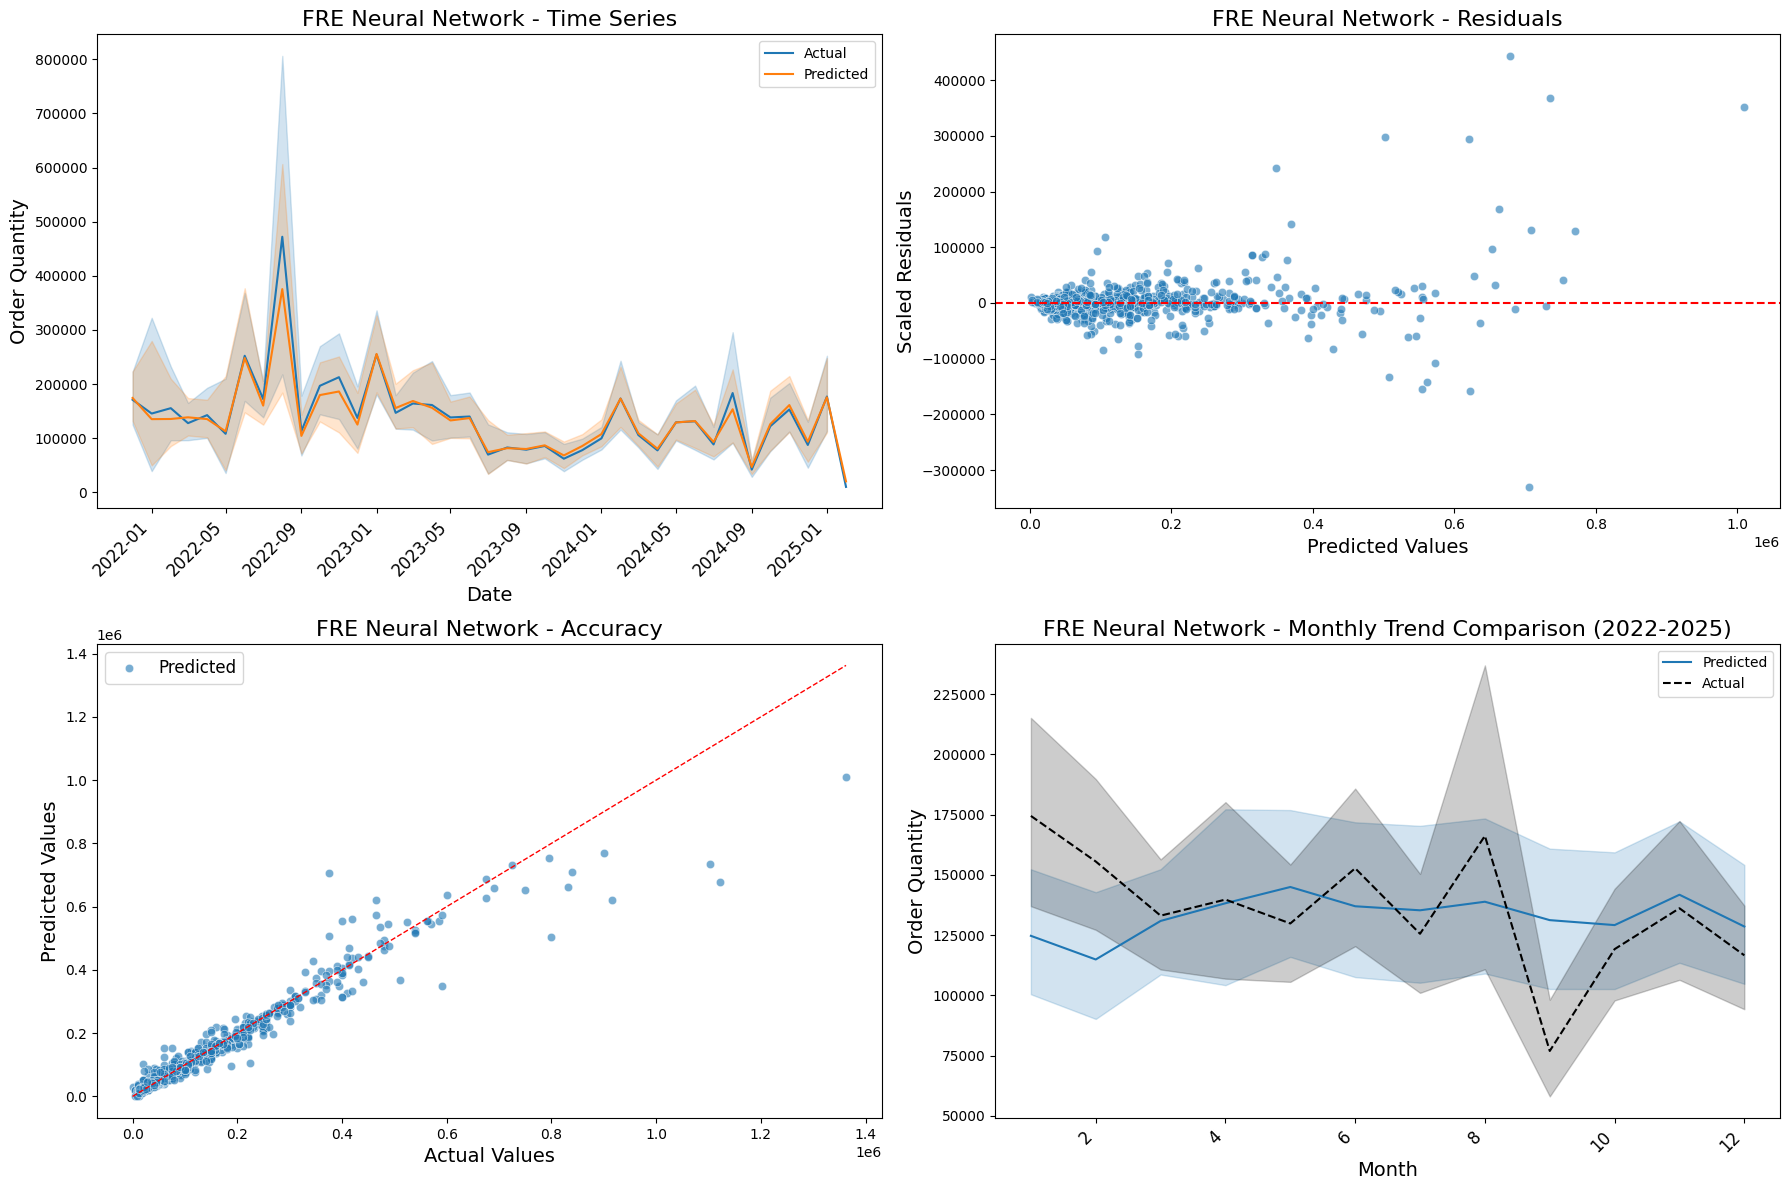

In [23]:
# Create subplots (2 rows, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12)) 
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Time Series Comparison
sns.lineplot(x=custom_code_df.loc[y_val.index, 'OrderDate'], y=y_val, label='Actual', ax=axes[0, 0])
sns.lineplot(x=custom_code_df.loc[y_val.index, 'OrderDate'], y=y_pred_ensemble, label='Predicted', ax=axes[0, 0])
axes[0, 0].set_title(f'{custom_ref} Neural Network - Time Series', fontsize=16)
axes[0, 0].set_xlabel('Date', fontsize=14)  
axes[0, 0].set_ylabel('Order Quantity', fontsize=14)

# Residual Plot
residuals = y_val - y_pred_ensemble
sns.scatterplot(x=y_pred_ensemble, y=residuals, alpha=0.6, ax=axes[0, 1])
axes[0, 1].axhline(0, color='r', linestyle='--')
axes[0, 1].set_title(f'{custom_ref} Neural Network - Residuals', fontsize=16)  
axes[0, 1].set_xlabel('Predicted Values', fontsize=14)  
axes[0, 1].set_ylabel('Scaled Residuals', fontsize=14)

# Actual vs Predicted Scatter Plot
min_val = min(y_val.min(), y_pred_ensemble.min())
max_val = max(y_val.max(), y_pred_ensemble.max())
sns.scatterplot(x=y_val, y=y_pred_ensemble, alpha=0.6, ax=axes[1, 0], label='Predicted')
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)  # Reference line
axes[1, 0].set_title(f'{custom_ref} Neural Network - Accuracy', fontsize=16)
axes[1, 0].set_xlabel('Actual Values', fontsize=14)
axes[1, 0].set_ylabel('Predicted Values', fontsize=14)  
axes[1, 0].legend(fontsize=12)

# Monthly Trend Comparison
monthly_data = custom_code_df[['order_month']].loc[custom_code_df.index.intersection(X_val.index)].copy()
monthly_data['Actual'] = y_val
monthly_data['Predicted'] = y_pred_ensemble

sns.lineplot(x='order_month', y='Predicted', data=monthly_data, label='Predicted', ax=axes[1, 1])
sns.lineplot(x='order_month', y='Actual', data=monthly_data, label='Actual', ax=axes[1, 1], color='black', linestyle='--')
axes[1, 1].set_title(f'{custom_ref} Neural Network - Monthly Trend Comparison (2022-2025)', fontsize=16)  
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Order Quantity', fontsize=14)

# Adjust x-tick labels after all plots are drawn
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.tight_layout()
plt.show()
